In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
import matplotlib.pyplot as plt
import aipy
from astropy.io import fits
from scipy.stats import linregress
import os
import glob

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [26]:
def curve_to_fit(lsts, gain, offset):
    '''
    Define curve to fit data to
    offset is Tsys offset from zero = Trxr + g * <Tsky>
    '''
    global interp_values
    return (gain * interp_values + offset)

In [27]:
JD = 2458098

Tsky_file = '/Users/tyler/Folders/Research/HERA/Tsys/data/HERA_tsky_fast.npz'
data = np.load(Tsky_file)
freqs = data['freqs']  # These are already made to fit the data
model_lsts = data['lsts']
model_HERA_Tsky = data['HERA_Tsky']

data = np.load('/Users/tyler/Folders/Research/HERA/Tsys/Tsys_plots/IDR2/2458098/fits.npz'.format(JD))
nrao_feeds = data['nrao_feeds']
HERA_list = data['HERA_list']
freqs = data['freqs']

In [28]:
pols = ['X', 'Y']
npol = len(pols)
nant = len(HERA_list)

Tsky_mean = np.mean(model_HERA_Tsky, axis=2)
Tsky_prime = model_HERA_Tsky - np.expand_dims(Tsky_mean, 2)

In [29]:
auto_fits = np.zeros((npol, len(freqs), 2))  # gain_amp, gain_slope, rxr_amp
covs = np.zeros((npol, len(freqs), 2, 2))

sim = True

if os.path.exists('/Users/tyler/Folders/Research/HERA/Tsys/Tsys_plots/IDR2/{}/rxr_temp_w_err.npz'.format(JD)) and not sim:
    fits_data = np.load('/Users/tyler/Folders/Research/HERA/Tsys/Tsys_plots/IDR2/{}/rxr_temp_w_err.npz'.format(JD))
    gains = fits_data['gains']
    rxr_temp_err = fits_data['rxr_temp_err']
    rxr_temp = fits_data['rxr_temp']
    covs = fits_data['covs']
    auto_fits = fits_data['auto_fits']
    
else:
    for pol in xrange(npol):
        for fi, freq in enumerate(freqs):
            interp_values = Tsky_prime[pol, fi, :]
            out = curve_fit(curve_to_fit, model_lsts, Tsky_prime[pol, fi, :],
                            bounds=(-1, np.inf))
            auto_fits[pol, fi, :] = out[0]
            covs[pol, fi, :, :] = out[1]

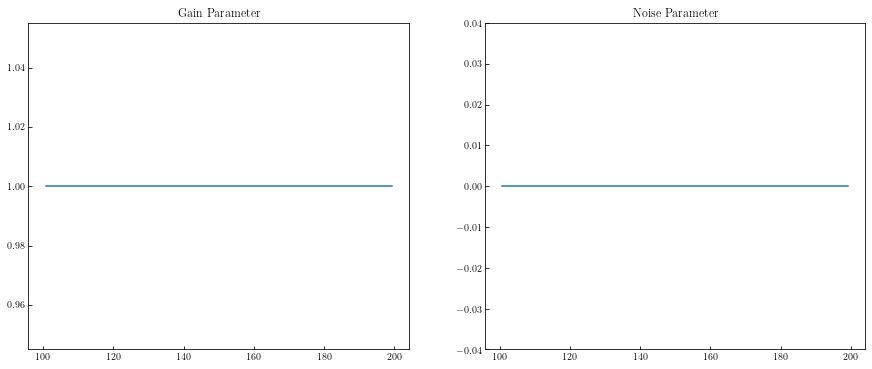

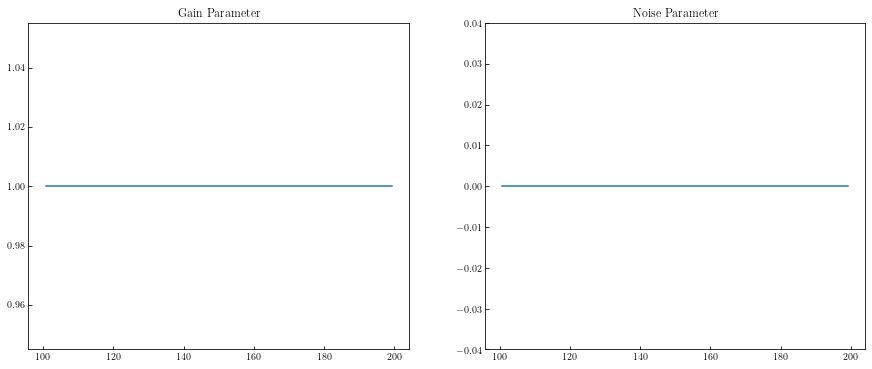

In [34]:
for poli in np.arange(npol):
    fig, axarr = plt.subplots(1, 2, figsize=(15,6))
    axarr[0].plot(freqs, auto_fits[poli, :, 0])
    axarr[1].plot(freqs, auto_fits[poli, :, 1])
    axarr[1].set_ylim([-0.04, 0.04])
    axarr[0].set_title('Gain Parameter')
    axarr[1].set_title('Noise Parameter')
    plt.show()

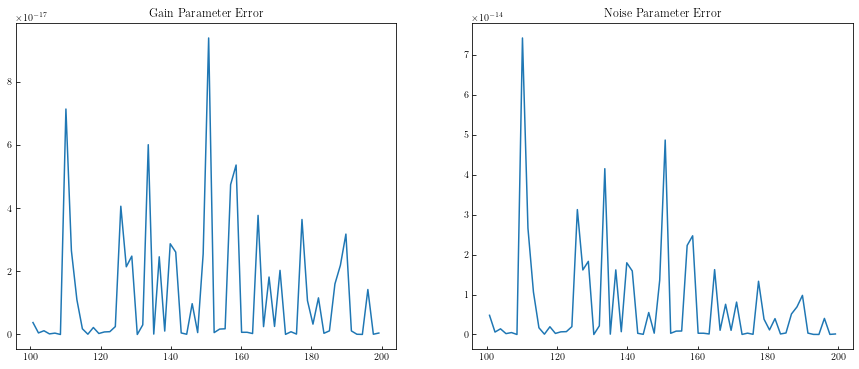

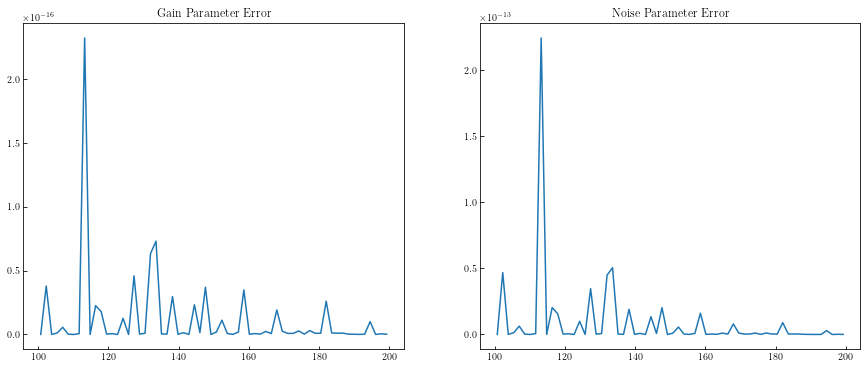

In [35]:
for poli in np.arange(npol):
    fig, axarr = plt.subplots(1, 2, figsize=(15,6))
    axarr[0].plot(freqs, np.sqrt(covs[poli, :, 0, 0]))
    axarr[1].plot(freqs, np.sqrt(covs[poli, :, 1, 1]))
    axarr[0].set_title('Gain Parameter Error')
    axarr[1].set_title('Noise Parameter Error')
    plt.show()